# Start Pooling

In [2]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib

from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.algorithms.soo.nonconvex.ga import GA
from pooling_functions_ciullo import calc_pool_conc, PoolOptimizationProblem
from pymoo.optimize import minimize
from pymoo.operators.repair.rounding import RoundingRepair

In [ ]:
from scipy.special import comb
from math import factorial

def stirling_number_scipy(n, x):
    if x > n or x <= 0:
        return 0  # No valid partitions if x > n or x <= 0
    return int(sum((-1)**(x-k) * comb(x, k) * (k**n) for k in range(1, x+1)) / factorial(x))

# Example: Calculate the number of ways to split 5 elements into 3 partitions
n = 9
x = 3
c = 0
for i in range(x,n+1):
    print(i)
    c += stirling_number_scipy(n, i)
print(f"The number of ways to split {n} elements into {x} partitions is {c}")


## Define Countries and Variables for Cat Bond Development

In [13]:
#choose country
countries = [480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

pool_1 = [212, 776, 174]
pool_2 = [332]
pool_3 = [670, 548, 584]
pool_4 = [388, 242]

#set risk free rate, either single value or array
rf_rates = 0.00
#set risk muliplier reported by artems
artemis_multiplier = 4.54
#set sharpe ratio to beat
target_sharpe = 0.5
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#define bond setting
lower_share = 0.045
prot_rp = 250

#set alpha for risk diversification optimization
RT = 200
alpha = 1-1/RT 

#set max nominal for pool
max_nominal = 100000000000

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

In [148]:
#define empty dictionaries
bond_metrics_sng_dic = {}
returns_sng_dic = {}
premium_dic_sng_dic = {}
nominal_sng_dic = {}
pay_dam_df_sng_dic = {}
es_metrics_sng_dic = {}
int_grid_sng_dic = {}
imp_per_event_flt_sng_dic = {}
imp_admin_evt_flt_sng_dic = {}
ann_losses_dic = {}

In [149]:
for cty in countries:
    if cty in bond_metrics_sng_dic:
        print(f"Bond for {cty} already calculated, skipping.")
        continue
    print(f'Create bond for {cty}')
    if cty in countries_150:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=150,
                                                                                                                                                                grid_size=1000,
                                                                                                                                                                grid_specs=[3,3],
                                                                                                                                                                buffer_grid_size=5,
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plt_save=False)
    if cty in countries_30:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=30,
                                                                                                                                                                grid_size=1000,
                                                                                                                                                                grid_specs=[3,3],
                                                                                                                                                                buffer_grid_size=1,
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plt_save=False)  
    if cty in fiji:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=150,
                                                                                                                                                                grid_size=1000,
                                                                                                                                                                grid_specs=[3,3],
                                                                                                                                                                buffer_grid_size=5,
                                                                                                                                                                crs="EPSG:3832",
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plt_save=False)
    bond_metrics_sng_dic[cty] = bond_metrics
    returns_sng_dic[cty] = returns
    premium_dic_sng_dic[cty] = premium_dic
    nominal_sng_dic[cty] = nominal
    pay_dam_df_sng_dic[cty] = pay_dam_df
    es_metrics_sng_dic[cty] = es_metrics
    int_grid_sng_dic[cty] = int_grid
    imp_per_event_flt_sng_dic[cty] = imp_per_event_flt
    imp_admin_evt_flt_sng_dic[cty] = imp_admin_evt_flt
    ann_losses_dic[cty] = ann_losses

Create bond for 882


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_alt.py:91: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 713
The principal of the cat bond is: 251308348.279 [USD]
Principal as share of GDP: 0.289
Create bond for 308


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_alt.py:91: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in NA basin: 4888
The principal of the cat bond is: 351316422.884 [USD]
Principal as share of GDP: 0.337


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

### Create Multi-Country bond

In [150]:
tranches_array = np.array([200, 600, 1200])

nominal_dic = {}
pay_dam_df_dic = {}
for cty in countries:
    nominal_dic[cty] = nominal_sng_dic[cty]
    pay_dam_df_dic[cty] = pay_dam_df_sng_dic[cty]
    
ncf_pool_tot, premiums_pool_tot, premium_dic_pool_tot, nominal_pool_tot, es_metrics_pool_tot, MES_cty_pool_tot, tranches_tot = bond_fct.mlt_cty_bond(countries=countries,pay_dam_df_dic=pay_dam_df_dic,nominals_dic=nominal_dic, tranches_array=tranches_array, opt_cap=True)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:137: RuntimeWarning: invalid value encountered in divide
  tranches_loss_own =  np.array(tranche_losses)/tranches.at[i, 'nominal']
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 0.0%


In [125]:
sng_ann_ret = {}
sng_ann_losses = {}
nominals_sng = []
pool_tranches_ann_ret = {}
for cty in countries:
    sng_ann_ret[cty] = returns_sng_dic[cty]['Annual'][0] 
    sng_ann_losses[cty] = np.array(ann_losses_dic[cty]['losses'].apply(sum)) * nominal_sng_dic[cty]
    nominals_sng.append(nominal_sng_dic[cty])
sng_ann_losses = pd.DataFrame(sng_ann_losses)
sng_ann_ret_df = pd.DataFrame(sng_ann_ret)
bond_metrics_sng_dic_df = pd.DataFrame(bond_metrics_sng_dic)
es_metrics_df = pd.DataFrame(es_metrics_sng_dic)

for key in ncf_pool_tot:
    if key != 'Total':
        pool_tranches_ann_ret[key] = ncf_pool_tot[key] / tranches_tot.loc[tranches_tot['RP'] == key, 'nominal'].iloc[0]

pool_ann_ret = ncf_pool_tot['Total']

ValueError: If using all scalar values, you must pass an index

In [3]:
df_returns = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/sng_returns_regression.csv")
df_returns_pool = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/tranches_{str(iterator)}_returns_regression.csv")

In [4]:
#df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
#df_returns_pool = pd.DataFrame({f"{country} Returns": returns for country, returns in pool_tranches_ann_ret.items()})

r = np.mean(df_returns,axis=0)
r_pool= np.mean(df_returns_pool,axis=0)

# Create a covariance matrix
covar = df_returns.cov()
covar_pool = df_returns_pool.cov()

In [5]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_returns.columns)

p_ret_pool = [] # Define an empty array for portfolio returns
p_vol_pool = [] # Define an empty array for portfolio volatility
p_weights_pool = [] # Define an empty array for asset weights

num_assets_pool = len(df_returns_pool.columns)

num_portfolios = 10000  # Number of portfolios to simulate
alpha_port = 0.3

In [6]:
for _ in range(num_portfolios):
    weights = dirichlet([alpha_port] * num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, r) 
    p_ret.append(returns)
    var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # yearly standard deviation
    p_vol.append(sd)    

    weights_pool = dirichlet([alpha_port] * num_assets_pool)
    weights_pool = weights_pool/np.sum(weights_pool)
    p_weights_pool.append(weights_pool)
    returns_pool = np.dot(weights_pool, r_pool) 
    p_ret_pool.append(returns_pool)
    var_pool = covar_pool.mul(weights_pool, axis=0).mul(weights_pool, axis=1).sum().sum()# Portfolio Variance
    sd_pool = np.sqrt(var_pool) # yearly standard deviation
    p_vol_pool.append(sd_pool)

In [7]:
data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
data_pool = {'Returns':p_ret_pool, 'Volatility':p_vol_pool, 'Sharpe Ratio':np.array(p_ret_pool)/np.array(p_vol_pool)}

for counter, symbol in enumerate(df_returns.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

for counter, symbol in enumerate(df_returns_pool.columns.tolist()):
    data_pool[symbol+' weight'] = [w[counter] for w in p_weights_pool]

In [8]:
portfolios  = pd.DataFrame(data)
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]
portfolios.head() # Dataframe of the 10000 portfolios created


portfolios_pool  = pd.DataFrame(data_pool)
max_sharpe_idx_pool = portfolios_pool['Sharpe Ratio'].idxmax()
max_sharpe_portfolio_pool = portfolios_pool.loc[max_sharpe_idx_pool]

In [9]:
# Expected returns and covariance matrices
r = np.mean(df_returns, axis=0)  # Expected returns for df_returns
r_pool = np.mean(df_returns_pool, axis=0)  # Expected returns for df_returns_pool

covar = df_returns.cov()  # Covariance matrix for df_returns
covar_pool = df_returns_pool.cov()  # Covariance matrix for df_returns_pool

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun  # Return the optimized weights and the minimized risk

# Generate a series of target returns and corresponding risks
target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
risks = []

for target_return in target_returns:
    weights, risk = minimize_risk(target_return, r, covar)
    risks.append(risk)

## Repeat for the second data set (df_returns_pool)
risks_pool = []
target_returns_pool = np.linspace(np.min(r_pool), np.max(r_pool), 50)
for target_return in target_returns_pool:
    weights, risk = minimize_risk(target_return, r_pool, covar_pool)
    risks_pool.append(risk)


In [10]:
portfolios_tot = pd.concat([portfolios, portfolios_pool], axis=0)

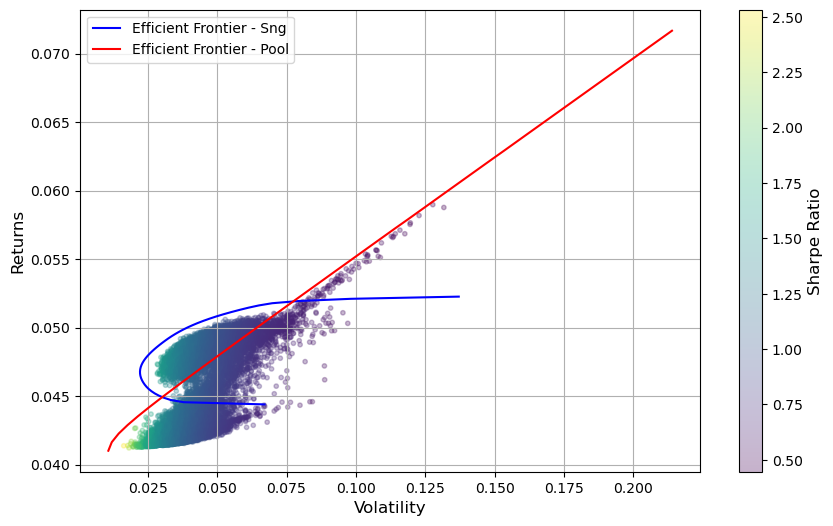

In [11]:
plt.figure(figsize=[10,6])

scatter = plt.scatter(
    x=portfolios_tot['Volatility'], 
    y=portfolios_tot['Returns'], 
    c=portfolios_tot['Sharpe Ratio'], 
    cmap='viridis', 
    marker='o', 
    s=10, 
    alpha=0.3
)    
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', fontsize=12)
plt.plot(risks, target_returns, label="Efficient Frontier - Sng", color='blue')
plt.plot(risks_pool, target_returns_pool, label="Efficient Frontier - Pool", color='red')
# Plot pool point
#plt.scatter(np.std(pool_ann_ret), np.mean(pool_ann_ret), label='Pool', color='purple', s=100)
#plt.text(np.std(pool_ann_ret)-0.01,np.mean(pool_ann_ret),f'Sharpe: {np.mean(pool_ann_ret)/np.std(pool_ann_ret):.2f}',fontsize=10,ha='right',va='center',color='purple')
#for cty in countries:
#    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


In [14]:
x = countries.copy()
x = [str(entry) for entry in x]
x.append('pool_1')
x.append('pool_2')
y = []
for cty in countries:
    y.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/bond_metrics_sng_dic[cty]['Summed Payments'][0])
y.append(np.sum(premiums_pool_tot['Total'])/(es_metrics_pool_tot['Payout']/nominal_pool_tot))
print(y)
plt.scatter(x,y)

NameError: name 'bond_metrics_sng_dic' is not defined

In [ ]:
s = []
s_pool = []
n = []
for cty in countries:
    s.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
    s_pool.append(np.sum(premiums_pool_tot[cty])*nominal_pool_tot)
    n.append(nominal_sng_dic[cty])

print((np.sum(premiums_pool_tot['Total'])*nominal_pool_tot)/np.sum(s))
print((nominal_pool_tot)/np.sum(n))
print(np.array(s_pool)/np.array(s))
country_str = [str(entry) for entry in countries]

plt.scatter(country_str, np.array(s_pool)/np.array(s))

In [7]:
sng_ann_losses = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/sng_losses.csv")
nominals_sng = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/nominals_sng.csv")
countries = [480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]

#columns_to_remove = ['192', '214']
## Save the indices of the columns to be removed
#indices_to_remove = [sng_ann_losses.columns.get_loc(col) for col in columns_to_remove]
#cty_to_remove = [192, 214]
#countries_opt = [x for x in countries if x not in cty_to_remove]
#
## Remove the columns from df1
#sng_ann_losses = sng_ann_losses.drop(columns=columns_to_remove)
#
## Remove the rows from df2 using the saved indices
#nominals_sng = nominals_sng[nominals_sng['Nominals'] <= 10000000000]
##nominals_sng = nominals_sng.drop(indices_to_remove, axis=0)

Repetitions: 100%|██████████| 5/5 [15:51<00:00, 190.29s/it]

  480 212 332 670 28  388 52  662 659 308  ... 780 192 570 84  776 90  174  \
0   3   4   2   4   3   2   1   4   2   3  ...   4   1   1   2   3   3   3   
1   3   1   3   1   4   3   2   1   3   4  ...   1   2   4   3   4   4   4   

  184 584 585  
0   2   3   4  
1   4   3   3  

[2 rows x 25 columns]


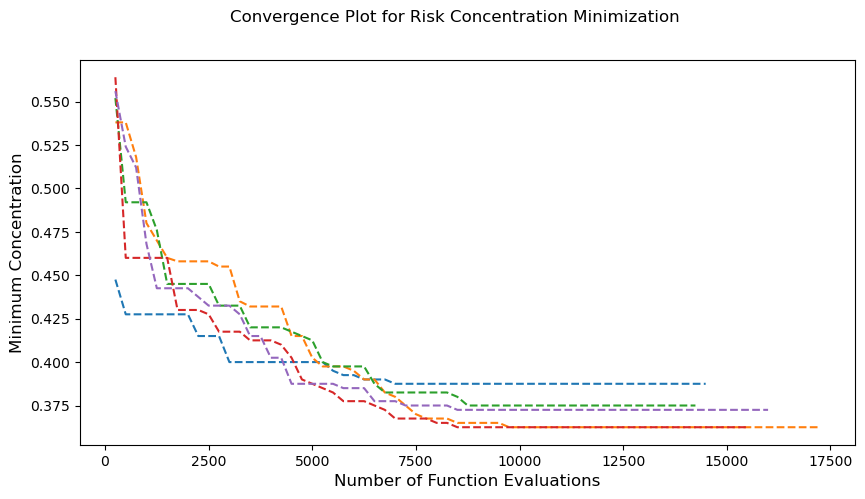

In [13]:
from tqdm import tqdm
#set number of repetitions of both minimizations (seed analysis)
n_opt_rep = 5
n = 5
opt_rep = range(0,n_opt_rep,1)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Convergence Plot for Risk Concentration Minimization')
#load names of countries in region which is optimized in
df_losses = sng_ann_losses.copy()
cntry_names = countries.copy()    
#optimize for each region to derive regional pool
#empty DataFrames to fill along the way (per region and GCM -> for each GCM seperate code file or change k)
#minimized concentration and number of countries (result of 1.Opt-Step and 2. Opt-Step)
df_conc = pd.DataFrame()
df_cntry_num = pd.DataFrame()
df_cntry_allocation = pd.DataFrame(columns = cntry_names)
#end result only with solutions with min_conc and min_cntry_num
df_result = pd.DataFrame(columns = cntry_names)
#dump with all results derived for all repetitions (--> cntry_allocation, min_conc, min_cntr, (n_gen, max_n_evals for each rep) saved)
df_result_dump = pd.DataFrame()
#Bool df where > VAR200
bools = df_losses >= np.quantile(df_losses, alpha, axis=0)
#loop through repetitions for seed analysis
for index in tqdm(opt_rep, desc=f'Repetitions'):
    #Problem definition
    problem = PoolOptimizationProblem(nominals_sng, max_nominal, df_losses, bools, alpha, n, calc_pool_conc)

    algorithm = GA(
        pop_size=250,
        sampling = IntegerRandomSampling(),
        crossover = HalfUniformCrossover(prob=0.1),
        mutation = PolynomialMutation(repair=RoundingRepair()),
        eliminate_duplicates=True,
    )

    # Solve the problem
    res_reg = minimize(problem,
                       algorithm,
                       verbose=False,
                       save_history=True)
    
    #Indices for full regional country list
    x = res_reg.X
    sorted_unique = sorted(set(x))
    rank_dict = {value: rank + 1 for rank, value in enumerate(sorted_unique)}
    x = [rank_dict[value] for value in x]

    #test if country composition was already derived in previous run, if yes not appended, in not appended as new solution
    if df_cntry_allocation.empty or not (df_cntry_allocation == x).all(axis=1).any():
        df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
        df_conc = pd.concat([df_conc, pd.DataFrame([res_reg.F], columns=['Min_Concentration'])], ignore_index=True)
        df_cntry_num = pd.concat([df_cntry_num, pd.DataFrame([np.sum(res_reg.X)], columns=['Country_Count'])], ignore_index=True)
    else:
        None

    #new_row to dump all results with all specs derived in the two optimization steps
    new_row = pd.DataFrame(columns=[cntry_names, 
                                    'min_conc', 
                                    'min_cntry_num', 
                                    'n_gen1', 
                                    'n_eval1_max'])
    new_row = pd.DataFrame([x], columns=cntry_names)
    new_row['min_conc'] = pd.DataFrame([res_reg.F], columns = ['min_conc'])
    new_row['min_cntry_num'] = pd.DataFrame([np.sum(res_reg.X)], columns=['min_cntry_num'])
    #input for convergence plot per repetition for res_reg
    n_evals = np.array([e.evaluator.n_eval for e in res_reg.history])
    opt = np.array([e.opt[0].F for e in res_reg.history])
    ax.plot(n_evals, opt, '--')
    ax.set_ylabel('Minimum Concentration', fontsize=12)
    ax.set_xlabel('Number of Function Evaluations', fontsize=12)

    #convergence results for new_row (dump) from res_reg
    new_row['n_gen1'] = pd.DataFrame([res_reg.algorithm.n_gen], columns = ['n_gen1'])
    new_row['n_eval1_max'] = pd.DataFrame([n_evals.max()], columns=['n_eval1_max'])
    #append new_row to dump
    df_result_dump = pd.concat([df_result_dump, new_row], ignore_index=True)

min_conc = df_conc['Min_Concentration'].min()
#find indices where conc minimized (constraint for opt step 1)
ind_min_conc = df_conc.index[df_conc['Min_Concentration'] == min_conc].tolist() 

ind_min = list(set(ind_min_conc))

#reduce full df with cntry allocations to the rows where constraint 1 is reached
df_result = df_cntry_allocation.loc[ind_min].reset_index(drop=True)
print(df_result)
#df_result.to_csv(OUTPUT_DIR.joinpath("pooling_results.csv"), index=False, sep=',')

In [88]:
row = df_result.iloc[0]

# Find column names where the values are the same as the first value
groups = row.groupby(row).apply(lambda x: x.index.tolist())

# Print the column names for each group
for group_value, columns in groups.items():
    print(f"Group {group_value}: {columns}")

Group 1: [52, 44, 882, 192, 570, 90, 584, 585]
Group 2: [28, 214, 84, 184]
Group 3: [480, 308, 548, 776, 174]
Group 4: [212, 670, 662, 780]
Group 5: [332, 388, 659, 242]


In [164]:
import itertools
import numpy as np

def generate_all_two_pools(num_countries):
    """
    Generate all possible ways to split `num_countries` into two pools.
    
    Args:
        num_countries (int): Total number of countries.
        
    Returns:
        list of numpy arrays: Each array represents a solution where each
                              country is assigned to one of the two pools.
    """
    countries = np.arange(num_countries)
    all_solutions = []
    
    # Generate all possible partitions
    for r in range(1, num_countries // 2 + 1):  # Iterate from 1 to half the countries
        for pool_a in itertools.combinations(countries, r):
            pool_b = tuple(set(countries) - set(pool_a))
            
            # Create a solution array where 0 represents Pool A and 1 represents Pool B
            solution = np.zeros(num_countries, dtype=int)
            solution[list(pool_b)] = 1  # Assign Pool B to 1
            
            all_solutions.append(solution)
    
    return all_solutions

# Example usage
num_countries = 25
all_solutions = generate_all_two_pools(num_countries)

# Print the number of solutions and an example
print(f"Number of solutions: {len(all_solutions)}")
print("Example solution:", all_solutions[0])


Number of solutions: 16777215
Example solution: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
